In [2]:
# prerequisites:
# pip install -U swifter[groupby]
import swifter 

import pandas as pd
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn import linear_model

In [3]:
# HYPER-PARAMETERS 
NOISE_FACTOR = 2  # кол-во шумовых фотонов по отношению к правильным
MINIMUM_FOTONS_NUMBER = 4  # Не рассматриваем случаи с меньшим чем MINIMUM_FOTONS_NUMBER числом фотонов
NUMBER_OF_CASES = 100000 # Кол-во случаев для оценки
BAND_WIDTH = 5 # Половина ширины полоски, в которой считаются фотоны
BAND_ROTATIONS_NUMBER = 100 # число поворотов для определения оптимального угла. минимальный угол поворота = 360гр/BAND_ROTATIONS_NUMBER 

In [4]:
df = pd.read_hdf("./data/Out_fin_pad(200)_x(-1.0,1.0)_E(0.01,10000.0)_eff(0.8)_102.h5")

In [5]:
df

,a,inc,Z,Num,E0,Eg,Bp,fi_orb,tet_orb,fi,tet,x0,y0,z0,x_det,y_det,x_det_pad,y_det_pad
0,6.0,0.0,1.0,0.0,5.917,0.0000,0.2502,18.0,90.0,287.5397,17.1861,6.4406,2.0924,-0.0001,-0.1167,0.7928,88.0,179.0
1,6.0,0.0,1.0,0.0,5.917,3366.0648,0.2502,18.0,90.0,287.5397,17.1861,6.4506,2.0926,-0.0010,-0.0009,0.7967,99.0,179.0
2,6.0,0.0,1.0,0.0,5.917,0.9858,0.2490,18.0,90.0,287.5397,17.1861,6.4585,2.0929,-0.0017,0.1477,0.7424,114.0,174.0
3,6.0,0.0,1.0,0.0,5.917,6.0639,0.2480,18.0,90.0,287.5397,17.1861,6.4635,2.0930,-0.0021,0.2700,0.7550,127.0,175.0
4,6.0,0.0,1.0,0.0,5.917,3.1189,0.2467,18.0,90.0,287.5397,17.1861,6.4735,2.0933,-0.0030,0.6106,0.7557,161.0,175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611082,4.0,0.0,-1.0,299996.0,14.658,5149.9423,0.1730,18.0,90.0,228.4404,53.9840,6.4732,2.0746,0.0242,0.1274,0.9839,112.0,198.0
1611083,1.0,0.0,1.0,299997.0,4.028,0.0000,0.2290,18.0,90.0,50.0309,78.0661,6.4396,2.0931,-0.0006,-0.2695,-0.0098,73.0,99.0
1611084,3.0,0.0,1.0,299998.0,23.657,0.0000,0.2620,18.0,90.0,56.6673,52.4806,6.4400,2.0932,-0.0004,0.8679,0.0061,186.0,100.0
1611085,3.0,0.0,1.0,299998.0,23.657,1967.6465,0.2620,18.0,90.0,56.6673,52.4806,6.4430,2.0997,-0.0039,0.8800,0.0248,187.0,102.0


In [6]:
# генерирует шум
def generate_uniform(df, size):
    size_df = len(df)
    xarr = uniform.rvs(scale = 199, size = size * size_df)
    yarr = uniform.rvs(scale = 199, size = size * size_df)
    return pd.DataFrame({'x_det_pad': xarr.astype(int), 'y_det_pad': yarr.astype(int)})

In [7]:
# определяет, лежит ли точка (px,py) в (верхней) полуплоскости, образуемой прямой, проходящей через (x0,y0), (x1,y1)
def point_belongs_to_semiplane(x0,y0,x1,y1,px,py):
    return np.cross([x1-x0, y1-y0], [px-x0,py-y0]) >= 0

In [8]:
# определяет, лежит ли точка в полосе шириной +-width, проходящую через точку (x0,y0) под углом alpha
def point_belongs_to_band(px,py, x0,y0, alpha, width):
    x1 = x0 + np.cos(alpha)
    y1 = y0 + np.sin(alpha)
    
    width_x = - width * np.sin(alpha)
    width_y = width * np.cos(alpha)
    return (not point_belongs_to_semiplane(x0 + width_x, y0 + width_y,x1 + width_x, y1 + width_y, px, py) and
        point_belongs_to_semiplane(x0 - width_x, y0 - width_y,x1 - width_x, y1 - width_y, px, py) and
        not point_belongs_to_semiplane(x0 - width_x, y0 - width_y, x0 + width_x, y0 + width_y, px, py))

In [9]:
# считает кол-во фотонов, попадающих в полосу шириной +-width, проходящую через точку (x0,y0) под углом alpha
def count_points_in_band(df, x0, y0, alpha, width):         
    x1 = x0 + np.cos(alpha)
    y1 = y0 + np.sin(alpha)
    
    width_x = - width * np.sin(alpha)
    width_y = width * np.cos(alpha)
   
    count = 0   
    for index, row in df.iterrows():
        x = row['x_det_pad']
        y = row['y_det_pad']
        if (not point_belongs_to_semiplane(x0 + width_x, y0 + width_y,x1 + width_x, y1 + width_y, x, y) and
            point_belongs_to_semiplane(x0 - width_x, y0 - width_y,x1 - width_x, y1 - width_y, x, y) and
            not point_belongs_to_semiplane(x0 - width_x, y0 - width_y, x0 + width_x, y0 + width_y, x, y)
           ):
            count += 1
    
    return count

In [10]:
# находит оптимальный угол поворота для отдельного эксперимента путем полного перебора
def find_max_alfa(df, x0, y0, width):
    alpha_max = 0
    cmax = 0
    for alpha in np.arange(-np.pi, np.pi, 2*np.pi/BAND_ROTATIONS_NUMBER):
        c = count_points_in_band(df, x0, y0, alpha, width)
        if c > cmax:
            cmax = c
            alpha_max = alpha
            
    return alpha_max

In [11]:
# оцениваем точность наивного метода для конкретного эксперимента
def prepare_data(df, width):   
    # не рассматриваем случаи с малым числом фотонов
    if len(df) < MINIMUM_FOTONS_NUMBER:
        return
    
    # находим порождающую частицу
    particle = df.query('Eg == 0')
    # не рассматриваем случаи с двумя и более частицами
    if len(particle) > 1:
        return
    
    # находим координаты этой частицы
    x0 = float(particle.iloc[0]['x_det_pad'])
    y0 = float(particle.iloc[0]['y_det_pad'])
       
    # для оценки точности модели шум добавляем до определения угла поворота
    # noise = generate_uniform(df, NOISE_FACTOR)
    # df_and_noise = pd.concat([df, noise])
    
    # определяем нужный угол поворота
    # alpha_max = find_max_alfa(df_and_noise, x0, y0, width)
    alpha_max = find_max_alfa(df, x0, y0, width)
    
    return pd.DataFrame({'x': [x0], 'y': [y0], 'alpha': [alpha_max], 'Zclass':[particle.iloc[0]['Z']>0]})

In [12]:
def plot_elements(df, low=0, up=200):
    fig, ax = plt.subplots(figsize=(5,5))
  
    plt.xlim(low,up)
    plt.ylim(low,up)
    particle = df.query('Eg == 0')
    df = df.drop(df[df.Eg == 0].index)
    
    data = df[df.Num.notnull()]
    noise = df[df.Num.isna()]
    
    ax.scatter(data[['x_det_pad']], data[['y_det_pad']], s=2)
    ax.scatter(noise[['x_det_pad']], noise[['y_det_pad']], s=1, facecolor='green')
    ax.scatter(particle[['x_det_pad']], particle[['y_det_pad']], facecolor='red', s=2)
    return fig, ax

In [13]:
# группируем данные по номеру эксперимента, для каждой группы запускаем оценку
trainData = df.query('Num < @NUMBER_OF_CASES').swifter.groupby("Num").apply(lambda x: prepare_data(x, BAND_WIDTH))

  0%|          | 0/64 [00:00<?, ?it/s]

2024-03-10 12:44:11,103	INFO worker.py:1673 -- Started a local Ray instance.


In [14]:
trainData

,,x,y,alpha,Zclass
Num,,,,,
0.0,0,88.0,179.0,-0.062832,True
1.0,0,120.0,54.0,2.387610,False
2.0,0,82.0,89.0,-0.251327,True
3.0,0,61.0,124.0,0.062832,True
4.0,0,173.0,46.0,-0.125664,True
...,...,...,...,...,...
99991.0,0,152.0,7.0,2.953097,False
99992.0,0,5.0,68.0,-0.376991,True
99993.0,0,78.0,36.0,-0.628319,False


In [15]:
xP = trainData.query('Zclass')['alpha'].to_numpy()
xN = trainData.query('not Zclass')['alpha'].to_numpy()
xP1 = trainData.query('Zclass')['x'].to_numpy()
xN1 = trainData.query('not Zclass')['x'].to_numpy()
xP2 = trainData.query('Zclass')['y'].to_numpy()
xN2 = trainData.query('not Zclass')['y'].to_numpy()

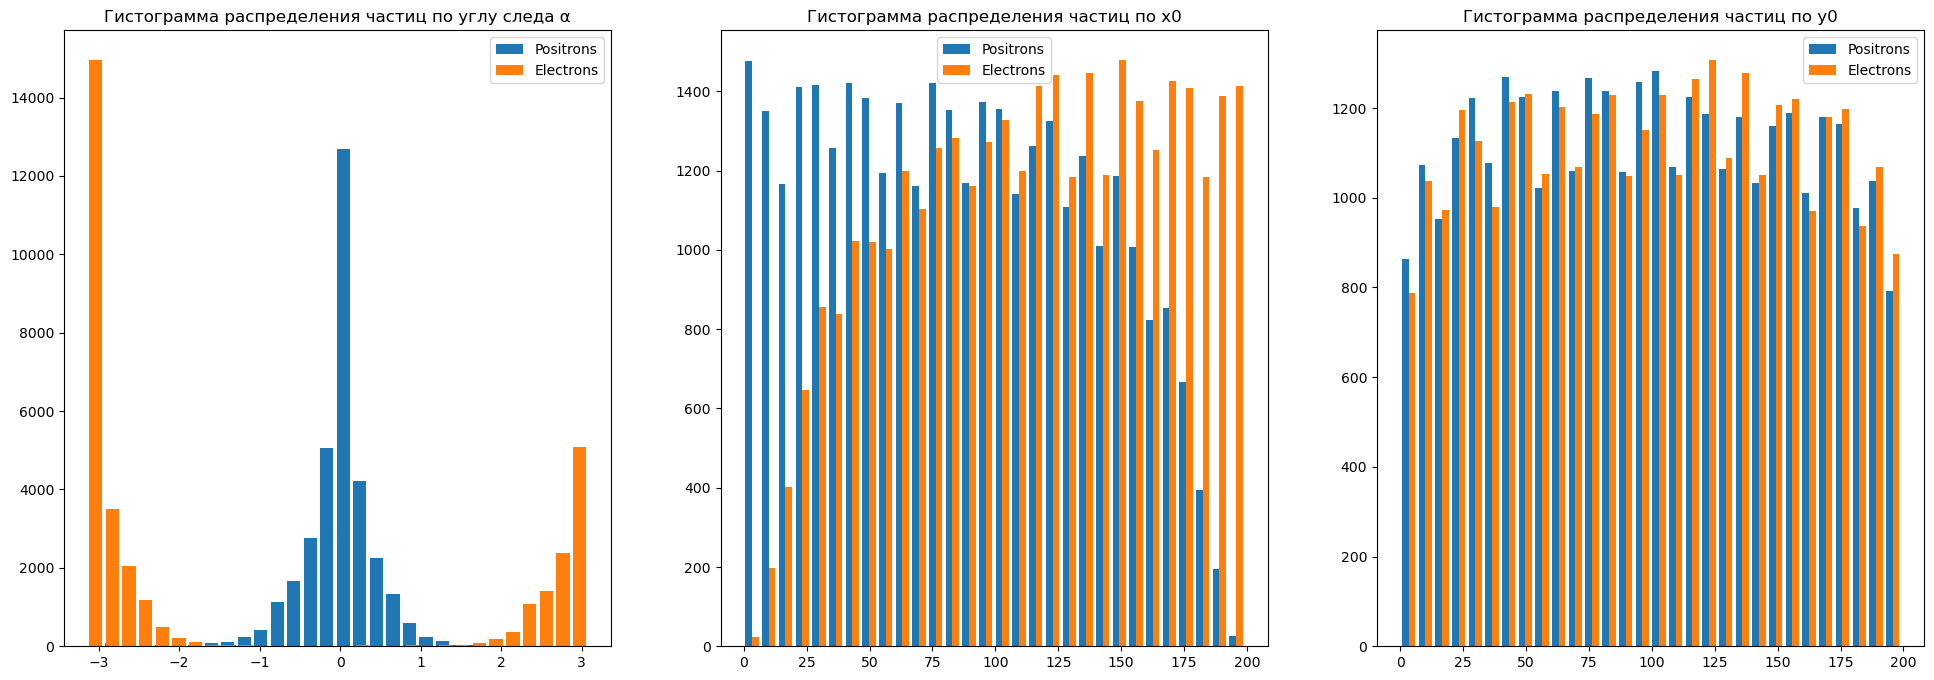

In [16]:
fig, (ax, ax1, ax2) = plt.subplots(figsize=(24,8),nrows=1, ncols=3)
ax.hist(xP, bins= 30, histtype='bar', rwidth=0.8, label='Positrons')
ax.hist(xN, bins= 30, histtype='bar', rwidth=0.8, label='Electrons')
ax.set_title('Гистограмма распределения частиц по углу следа α')
ax.legend(prop={'size': 10})

ax1.hist([xP1, xN1], bins= 30, histtype='bar', rwidth=0.8, label=['Positrons','Electrons'])
#ax1.hist(xP1, bins= 30, histtype='bar', rwidth=0.8, label='Electrons')
ax1.set_title('Гистограмма распределения частиц по x0')
ax1.legend(prop={'size': 10})

ax2.hist([xP2,xN2], bins= 30, histtype='bar', rwidth=0.8, label=['Positrons','Electrons'])
ax2.set_title('Гистограмма распределения частиц по y0')
ax2.legend(prop={'size': 10})



In [17]:
X = trainData[['alpha']].to_numpy()
y = trainData['Zclass'].transpose().to_numpy()

In [18]:
#========================================================================================
# CLASSIFIER TRAINING
#========================================================================================
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import pickle

In [19]:
ds = (X, y)
names = [
    #"Nearest Neighbors",
    #"RBF SVM",
    "Poly SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    #"Neural Net",
    #"AdaBoost",
    #"QDA",
]

# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py
classifiers = [
    #KNeighborsClassifier(3),
    #SVC(gamma=2, C=1, random_state=42),
    SVC(kernel="poly", C=1, degree=2, random_state=42),   
    #GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=2, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    #MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    #AdaBoostClassifier(random_state=42),
    #QuadraticDiscriminantAnalysis(),
]

In [20]:
# preprocess dataset, split into training and test part
X, y = ds
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
       
    # save model
    pickle.dump(clf, open(name + ".model", "wb"))
    # load model
    #loaded_model = pickle.load(open(filename, "rb"))

    score = clf.score(X_test, y_test)
    print(name, score)


Poly SVM 0.9868484961703717
Decision Tree 0.9870353073043153
Random Forest 0.9870353073043153


In [21]:
clf = pickle.load(open("Decision Tree.model", "rb"))


[Text(0.5, 0.8333333333333334, 'x[0] <= -1.665\ngini = 0.5\nsamples = 40146\nvalue = [20008, 20138]'),
 Text(0.25, 0.5, 'x[0] <= -1.979\ngini = 0.042\nsamples = 13746\nvalue = [13454, 292]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.036\nsamples = 13608\nvalue = [13360, 248]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.434\nsamples = 138\nvalue = [94, 44]'),
 Text(0.75, 0.5, 'x[0] <= 1.665\ngini = 0.373\nsamples = 26400\nvalue = [6554, 19846]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.019\nsamples = 20006\nvalue = [193, 19813]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.01\nsamples = 6394\nvalue = [6361, 33]')]

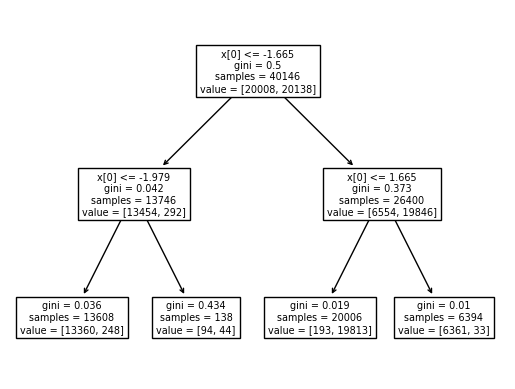

In [22]:
tree.plot_tree(clf)

In [25]:
testData = df.query('(Num > @NUMBER_OF_CASES) and (Num < 2 * @NUMBER_OF_CASES)').swifter.groupby("Num").apply(lambda x: prepare_data(x, BAND_WIDTH))

  0%|          | 0/64 [00:00<?, ?it/s]

In [28]:
X = testData[['alpha']].to_numpy()
y_true = testData['Zclass'].transpose().to_numpy()

In [29]:
y_pred = clf.predict(X)

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [35]:
accuracy_score(y_true, y_pred)

0.9873397031071222

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     33676
        True       0.99      0.98      0.99     33621

    accuracy                           0.99     67297
   macro avg       0.99      0.99      0.99     67297
weighted avg       0.99      0.99      0.99     67297



In [38]:
import ray
ray.shutdown()